<a href="https://colab.research.google.com/github/Ugo5738/Natural_language_processing_projects/blob/main/Deploying_Sentiment_Analysis_Transfer_Learning_with_Tensorflow_Serving(tweets_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue May 11 00:23:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Install dependencies

In [2]:
try:
    %tensorflow_version 2.x
except:
    pass

In [3]:
import os
import json
import tempfile
import requests

import re
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split 

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pathlib
import shutil
import tempfile

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
from  IPython import display

!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

print("\u2022 using Tensorflow version:", tf.__version__)

     |████████████████████████████████| 1.0MB 9.8MB/s 
Version:  2.4.1
Hub version:  0.12.0
GPU is available
• using Tensorflow version: 2.4.1


# Handling Dataset

## Download Dataset from Kaggle

In [4]:
!pip install --quiet kaggle

# upload the kaggle.json file from your local system
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ugochukwunwachukwu","key":"bf40d33f01a1437a69ae5fb2505e2f7e"}'}

In [5]:
# make the /.kaggle directory
!mkdir -p ~/.kaggle

# copy the kaggle.json file into the /.kaggle directory
!cp kaggle.json ~/.kaggle
# check the files in the /.kaggle directory

!ls /root/.kaggle/
# check the file permission 

!ls -l ~/.kaggle/kaggle.json
# change file permission
# chmod 600 - owner can write and read
# chmod 700 - owner can write, read and execute

!chmod 600 ~/.kaggle/kaggle.json

kaggle.json
-rw-r--r-- 1 root root 74 May 11 00:23 /root/.kaggle/kaggle.json


In [6]:
!kaggle datasets list -s 'Sentiment140 dataset with 1.6 million tweets'

ref                                                    title                                          size  lastUpdated          downloadCount  
-----------------------------------------------------  --------------------------------------------  -----  -------------------  -------------  
kazanova/sentiment140                                  Sentiment140 dataset with 1.6 million tweets   81MB  2017-09-13 22:43:19          54873  
raohammas/sentimental-analysis-trained-model-on-mlnet  Sentimental Analysis trained Model on ML.Net  120MB  2020-10-28 18:25:53             12  
grwche/sentiment                                       Sentiment                                       2GB  2020-04-23 23:29:23            137  
malikhasan/16-million-sentiment-tweets                 1.6 million sentiment tweets                   81MB  2020-04-14 22:54:15             16  


In [7]:
!kaggle datasets download -d kazanova/sentiment140 

 80% 65.0M/80.9M [00:01<00:00, 47.3MB/s]
100% 80.9M/80.9M [00:01<00:00, 69.6MB/s]


## Data Wrangling

In [8]:
df = pd.read_csv('/content/sentiment140.zip', 
                 encoding = 'ISO-8859-1',
                 names = ['target','id','date','flag','user','text'],
                 compression='zip', # decompress this zip file
                 low_memory=False)

df = df[['text', 'target']]
df = df.sample(frac=1).reset_index(drop=True)

df.shape

(1600000, 2)

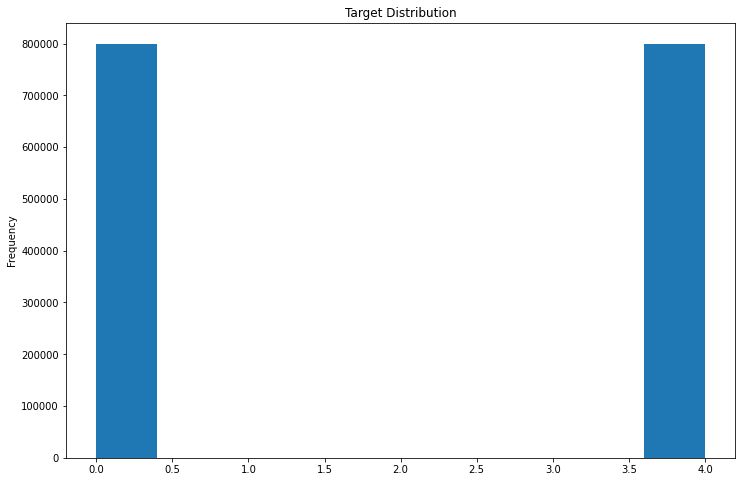

In [9]:
df['target'].plot(kind='hist', title='Target Distribution')

In [10]:
df.text.head(15).values

array(["Nap time  then going to get up and clean my room &quot;/ then at 8 I'm going to watch JONAS! Yay!!",
       '@beverlymusiq Get 100 followers a day using www.tweeterfollow.com Once you add everyone you are on the train or pay vip ',
       'No school tomorrow!! Oh yea ',
       'just got home, and so damn tired... my body feels so dirty with all the jakarta pollution, i need to take a bath.. wanting salon  ',
       'Looks like i will be drowned in work for the whole day! to add to its misery, I have a bad cold and fever too! ',
       'I need a Bones fix  So off to read and then maybe watch Bones ',
       'http://twitpic.com/6pbyz - Haha what do i look lyk just an average day with kirstyyy  she is the best x',
       "@Zeestermoe Eh... school starts on the 10th (I think), haha! Goodness me, I'll miss this place *sheds a tear* ",
       "i'm in complete twitter mode. Thanks for the two people Jess and Marc for booking with me ",
       '@Dorkus_ fellow scouser Ringo Star is min

In [11]:
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9,.']+"
# TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

"""
nltk.download('stopwords')

stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")


def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)
"""
# try this preprocessing and try to retain the stopwords
def preprocess(text, stem=False):
    # Remove link, user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text)).strip()
    tokens = []
    for token in text.split():
        tokens.append(token)

    return " ".join(tokens)

df.text = df.text.apply(lambda x: preprocess(x))

In [12]:
df.text.head(15).values

array(["Nap time then going to get up and clean my room quot then at 8 I'm going to watch JONAS Yay",
       'Get 100 followers a day using www.tweeterfollow.com Once you add everyone you are on the train or pay vip',
       'No school tomorrow Oh yea',
       'just got home, and so damn tired... my body feels so dirty with all the jakarta pollution, i need to take a bath.. wanting salon',
       'Looks like i will be drowned in work for the whole day to add to its misery, I have a bad cold and fever too',
       'I need a Bones fix So off to read and then maybe watch Bones',
       'Haha what do i look lyk just an average day with kirstyyy she is the best x',
       "Eh... school starts on the 10th I think , haha Goodness me, I'll miss this place sheds a tear",
       "i'm in complete twitter mode. Thanks for the two people Jess and Marc for booking with me",
       'fellow scouser Ringo Star is mine',
       'Everyone has iced coffee except me. Something is wrong with this. I think i

In [13]:
df.target.tail(15).values

array([0, 0, 0, 4, 4, 0, 0, 0, 4, 0, 0, 4, 4, 4, 0])

In [14]:
for index, value in enumerate(df.target.values):
    df.target.values[index] = 1 if (value == 4) else 0
        
df.target.tail(15).values

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0])

In [15]:
train_df, remaining = train_test_split(df, random_state=42, train_size=0.2, stratify=df.target.values) # stratify parameter will preserve the proportion of target as in original dataset, in the train and test datasets as well.
test_df, _ = train_test_split(remaining, random_state=42, train_size=0.07, stratify=remaining.target.values)
train_df.shape, test_df.shape

((320000, 2), (89600, 2))

# Building and Training Models

In [16]:
def train_and_evaluate_model(module_url, embed_size, name, trainable=False):
    hub_layer = hub.KerasLayer(module_url, output_shape=[embed_size], input_shape=[], dtype=tf.string, trainable=trainable)
    model = tf.keras.models.Sequential([hub_layer, # this would generate a fixed length output vector
                                        tf.keras.layers.Dense(256, activation='relu'),
                                        tf.keras.layers.Dense(64, activation='relu'),
                                        tf.keras.layers.Dense(1, activation='sigmoid')
                                        ])

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                  loss=tf.losses.BinaryCrossentropy(),
                  metrics=[tf.metrics.BinaryAccuracy(name='accuracy')]) # accuracy is not the best metric to use here because of the class imbalance. However, BinaryAccuracy calculates how often predictions match binary labels.
                  # the name parameter makes it easier for us to call the metrics for plotting

    model.summary()
    
    history = model.fit(train_df['text'], train_df['target'],
                        epochs=2,
                        batch_size=32,
                        validation_data=(test_df['text'], test_df['target']),
                        # validation_split=0.2,
                        verbose=1,
                        callbacks=[tfdocs.modeling.EpochDots(), # after an epoch is complete, it'll append a dot to a sequence so that the screen looks much more readable
                                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min'), # we are monitoring the validation loss and if after 2 consecutive epochs the validation doesn't improve then we will stop training. The mode is minimum because we are minizing the loss.
                                  tf.keras.callbacks.TensorBoard(logdir/name)] # specify that we want to log all the metrics in the log directory within a subdirectory given be the name of model.
                        )
    return history, model

## Train Various Text Classification Models

In [17]:
histories = {}

In [18]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [19]:
histories['universal-sentence-encoder-large-finetuned'], model = train_and_evaluate_model(module_url, embed_size=512, name='universal-sentence-encoder-large-finetuned', trainable=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 512)               147354880 
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 147,502,721
Trainable params: 147,502,721
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2


    6/10000 [..............................] - ETA: 2:02:05 - loss: 0.6908 - accuracy: 0.5962WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1076s vs `on_train_batch_end` time: 0.5033s). Check your callbacks.


10000/10000 [==============================] - 1321s 126ms/step - loss: 0.3908 - accuracy: 0.8252 - val_loss: 0.3505 - val_accuracy: 0.8428

Epoch: 0, accuracy:0.8344,  loss:0.3701,  val_accuracy:0.8428,  val_loss:0.3505,  
.Epoch 2/2
10000/10000 [==============================] - 1253s 125ms/step - loss: 0.2762 - accuracy: 0.8833 - val_loss: 0.3627 - val_accuracy: 0.8422
.

I tested all pretrained embeddings and found that the finetuned universal-sentence-encoder-large performed best on this dataset. Although, after epoch 1, it began to overfit.

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show() 

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()

# Test model

In [23]:
sentences = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

prediction = model.predict(sentences)
print(prediction)

[[0.98499125]
 [0.8942847 ]
 [0.03622527]]


# Save the Model

In [ ]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key

MODEL_DIR = tempfile.gettempdir()

version = 1

export_path = os.path.join(MODEL_DIR, str(version))

if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

# This is the actual code for saving the model
model.save(export_path, save_format="tf")

print('Saved model to export_path = {}\n'.format(export_path))
!ls -l {export_path}

## Examine Model

In [ ]:
!saved_model_cli show --dir {export_path} --all

# Tensorflow Serving

## Add Tensorflow Serving Distribution Url as a Package Source

In [20]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  14497      0 --:--:-- --:--:-- --:--:-- 14497
OK
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1

In [ ]:
# Install Tensorflow Serving

!apt-get install tensorflow-model-server

# Tensorflow Model Server

## Run the Tensorflow Model Server

In [ ]:

os.environ["MODEL_DIR"] = MODEL_DIR

In [ ]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=helloworld \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [ ]:

# Viewing Server log

!tail server.log

# Create JSON Object with Test Data

In [ ]:
sentence = "What a stupid thing to say and at the same time it is quite amazing to see that you can be honest in a time such as this!"
sequence = tokenizer.texts_to_sequences([sentence])
test_sentence = pad_sequences(sequence, maxlen=max_length, truncating=trunk_type)

data = json.dumps({"signature_name": "serving_default", "instances": test_sentence.tolist()})
print(data)

# Make Inference Request

In [ ]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/helloworld:predict', data=data, headers=headers)

print(json_response.text)

In [ ]:
prediction = json.loads(json_response.text)['predictions']
prediction = float(prediction[0][0])
print(prediction)

In [ ]:
if prediction > 0.5:
    print("This comment is positive")
elif prediction == 0.5:
    print("This comment is neutral")
else:
    print("This commment is negative")